# <center><font color='blue'>SkimLit</center></font>

## Table of contents
- [1 - Objectives](#1)
- [2 - Setup](#2)
- [3 - Data Loading and Visualization](#3)
- [4 - Data pre-processing](#4)
    - [4.1. - Formatting our data](#4.1)
    - [4.2. - More visualization](#4.2)
    - [4.3. - Categorical data](#4.3)
    - [4.4. - Pre-processing for NLP](#4.4)
    - [4.5. - Creating tensorflow datasets](#4.5)
- [5 - Models](#5)
    - [5.1. - Embedding layer](#5.1)
    - [5.2. - Trying different models](#5.2)
        - [5.2.1 - Model 1](#5.2.1)
        - [5.2.2 - Model 2](#5.2.2)
        - [5.2.3 - Model 3](#5.2.3)
        - [5.2.4 - Model 4](#5.2.4)
        - [5.2.5 - Model 5](#5.2.5)
- [6 - Compare results](#6)
- [7 - Conclusions](#7)
- [8 - References](#8)


<a name="1"></a>
## <b> <font color='blue'> 1. Objectives </font> </b>
Build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071



<a name="2"></a>
## <b> <font color='blue'> 2. Setup </font> </b>

What we are looking for is to associate a specific label (objective, background, result...) with a given sentence (composed of many words), so it is a many-to-one problem.

### Modules

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


In [2]:
import csv
import random
import re

import numpy as np

import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, Sequential, losses
from tensorflow import keras

from utils import plot_hist


2024-07-26 18:56:04.425535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 18:56:04.425568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 18:56:04.426684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# random seed
tf.random.set_seed(42)

<a name="3"></a>
## <b> <font color='blue'> 3.  Data Loading and Visualization </font> </b>

Let's download the data.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct 

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!dir pubmed-rct #ls

fatal: la ruta de destino 'pubmed-rct' ya existe y no es un directorio vacío.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


There are 2 datasets, one with 20000 examples (usefull for the initial tests) and another one with 200k examples.

In [5]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
# Let's read in the training lines and see some of them
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file

to_show = 15
train_lines[:to_show]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We see that the abstracts:

- Start with "###
- Followed by an ID and a newline character (\n)
- Each sentence has a label (for example RESULTS, METHODS..) (starting with the label and then \t)
- The end is indicated by a newline charecter (\n).

<br>
We need a function to separate the text from the labels and the different abstracts.

<a name="4"></a>
## <b> <font color='blue'> 4.  Data pre-processing </font> </b>


<a name="4.1"></a>
### <b> <font color='#1F618D'> 4.1. Formatting our data </font> </b>

We want that our data looks like this:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

total lines it's the number of lines in the abstract (that we want to classify sequentially)

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.


In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

          

In [11]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [12]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Let's create dataframes:

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<a name="4.2"></a>
### <b> <font color='#1F618D'> 4.2. More visualization </font> </b>

#### Number of classes and class balance

In [14]:
num_classes = train_df['target'].nunique()
num_classes

5

In [15]:
# Distribution of labels in training data
train_df.target.value_counts(normalize=True)

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64

#### Total lines distribution

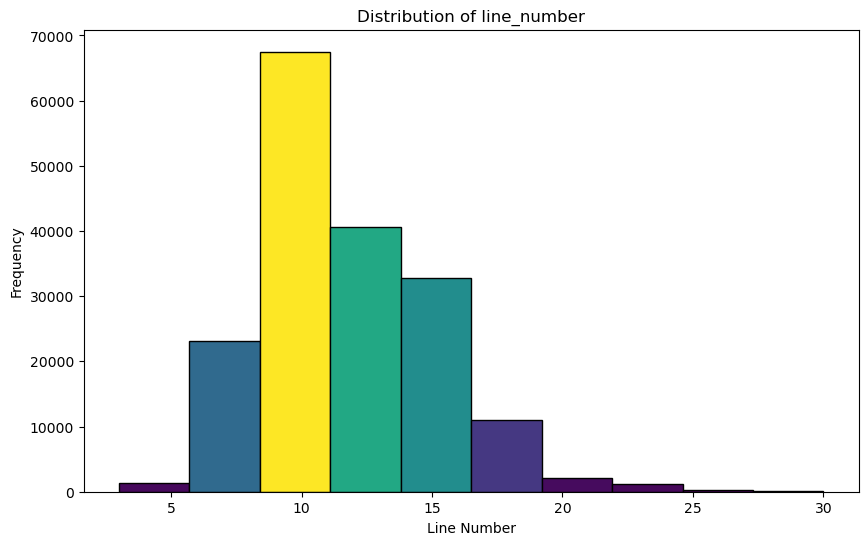

In [17]:
plot_hist(train_df['total_lines'], 'Distribution', 'Total lines', 'Frequency', 10)

#### Sentences

In [18]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [20]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

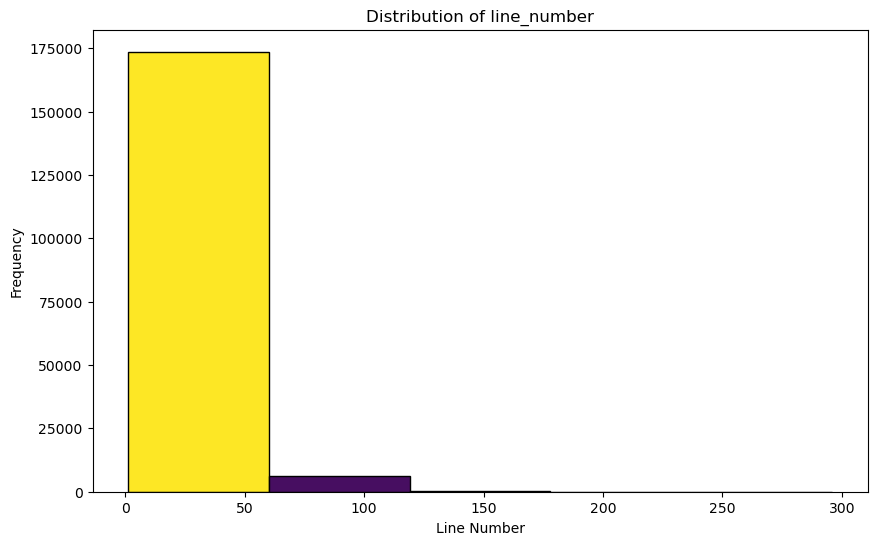

In [24]:
plot_hist(train_df['total_lines'], 'Distribution', 'Sentence length', 'Frequency', 5)

In [25]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [26]:
# Maximum sequence length in the training set
max(sent_lens)

296

<a name="4.3"></a>
### <b> <font color='#1F618D'> 4.3. Categorical Data </font> </b>

We will use one-hot encoding for our targets, since there are no ordinal relationship between them.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

# here there is no fit, we fit with the training data only
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

<a name="4.4"></a>
### <b> <font color='#1F618D'> 4.4. Pre-processing for NLP </font> </b>

#### Create text vectorizer layer

In [ ]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import TextVectorization


# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Let's observe that it pads with zeros up to the specified output sequence length (output_seq_length, which is 55 in this case).

In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

<b> 
We will apply it later as the first layer of the model after obtaining the input. </b>

<a name="4.5"></a>
### <b> <font color='#1F618D'> 4.5. Creating tensorflow datasets </font> </b>

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [ ]:
for x, y in train_dataset.take(1):
    print(f"Text: {x}\n")
    print(f"Label: {y}")

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

<a name="5"></a>
## <b> <font color='blue'> 5. Models </font> </b>

In [ ]:
from utils import store_results

In [ ]:
# to save results and compare
results = {}

In [ ]:
# constants
INPUT_SHAPE=(1,)
BATCH_SIZE = 32
NUM_CLASSES=num_classes

<a name="5.1"></a>
### <b> <font color='#1F618D'> 5.1. Embedding layer </font> </b>

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt 
                                               #numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

<a name="5.2"></a>
### <b> <font color='#1F618D'> 5.2. Trying different models </font> </b>

<a name="5.2.1"></a>
### <b> <font color='#5499C7'> 5.2.1. Model 1: Conv1D </font> </b>

In [ ]:
def build_model_1(name, input_shape = INPUT_SHAPE, num_classes = NUM_CLASSES):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = text_vectorizer(inputs)
    x = token_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_1 = build_model_1('model_1')

model_1.summary()

In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # one-hot encoded labels
    metrics=['accuracy', 'Precision', 'Recall']
)


history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    batch_size=BATCH_SIZE,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

In [ ]:
# save model
model_1.save('models/Model_1')

In [ ]:
loaded_model_1 = tf.keras.models.load_model('models/Model_1')

In [ ]:
# evaluate
score1 = loaded_model_1.evaluate(test_dataset)

In [ ]:
store_results(results, 'Model 1', score1);

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = loaded_model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<a name="5.2.2"></a>
### <b> <font color='#5499C7'> 5.2.2. Model 2: Feature extraction with pre-trained token embeddings </font> </b>

In [ ]:
import tensorflow_hub as hub

In [ ]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

In [ ]:
def build_model_2(name, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape, dtype=tf.string)
    x = tf_hub_embedding_layer()(inputs)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_2 = build_model_1('model_2_USE_feature_extractor')
    
model_2.summary()

In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # one-hot encoded labels
    metrics=['accuracy', 'Precision', 'Recall']
)


history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

In [ ]:
model_2.save('models/Model2')

In [ ]:
loaded_model_2 = tf.keras.models.load_model('models/Model2')

In [ ]:
# evaluate
score2 = loaded_model_2.evaluate(test_dataset)

In [ ]:
store_results(results, 'Model 2', score2);

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = loaded_model_2.predict(valid_dataset)
model_2_pred_probs

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<a name="5.2.3"></a>
### <b> <font color='#5499C7'> 5.2.3. Model 3: Conv1D with character embeddings </font> </b>

#### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

In [ ]:
# Crear el histograma
n, bins, patches = plt.hist(char_lens, bins=5, edgecolor='black')

# Colores para cada barra
colors = ['blue', 'cyan', 'green', 'purple', 'orange']

# Asignar un color a cada barra
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Mostrar el gráfico
plt.show()

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

#### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Each sentence has length 290 and the size of the embedding is 25.

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

In [ ]:
def build_model_3(name, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = char_vectorizer(inputs)
    x = char_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # try MaxPooling!!
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model

    
model_3 = build_model_3('model_3')

model_3.summary()

In [ ]:
# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", 'Precision', 'Recall'])

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

In [ ]:
model_3.save('models/Model_3')

In [ ]:
loaded_model_3 = tf.keras.models.load_model('models/Model_3')

In [ ]:
score3 = loaded_model_3.evaluate(test_char_dataset)

In [ ]:
store_results(results, 'Model 3', score3);

In [ ]:
# Make predictions with character model only
model_3_pred_probs = loaded_model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<a name="5.2.4"></a>
### <b> <font color='#5499C7'> 5.2.4. Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer) </font> </b>

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

<img src="images/model_4.png">


<br>
<center> <b>Figure</b> Model.</center>

crédtiso a la imagen!!!



In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
        # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # combine data and labels
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

In [ ]:
def build_model_4(name):
    # 1. Setup token inputs/model
    token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
    token_embeddings = tf_hub_embedding_layer(token_inputs)
    token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs,
                                 outputs=token_outputs)

    # 2. Setup char inputs/model
    char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embed(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
    char_model = tf.keras.Model(inputs=char_inputs,
                                outputs=char_bi_lstm)

    # 3. Concatenate token and char inputs (create hybrid token embedding)
    token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                      char_model.output])

    # 4. Create output layers
    combined_dropout = layers.Dropout(0.5)(token_char_concat)
    combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
    final_dropout = layers.Dropout(0.5)(combined_dense)
    output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

    # 5. Construct model with char and token inputs
    model = tf.keras.Model(inputs=[token_model.input, char_model.input],
                             outputs=output_layer,
                             name="model_4_token_and_char_embeddings")
    #
    return model


model_4 = build_model_4('Model 4')

model_4.summary()


In [ ]:
# to plot the model
from keras.utils import plot_model

In [ ]:
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy", 'Precision', 'Recall'])

# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

In [ ]:
model_4.save('models/Model_4')

In [ ]:
score4 = model_4.evaluate(test_char_token_dataset)

In [ ]:
store_results(results, 'Model 4', score4);

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(test_char_token_dataset)
model_4_pred_probs

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<a name="5.2.5"></a>
### <b> <font color='#5499C7'> 5.2.5. Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings</font> </b>

We are going to include positional embeddings because order is important; if a sentence is the first in an abstract, it is more likely to be the objective or the background, if it is the last one, it is more likely to be the conclusion...

In [ ]:
train_df.head()

> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

#### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

In [ ]:
# Check the distribution of "line_number" column
plot_hist(train_df['line_number'], 'Distribution of line number', 'Line number', 'Frequency', bins_number = 10)    


We cut it into 15 so that the vector is not too long, and as seen in the previous histogram,
the majority of our data falls in there.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape


Now we've encoded our line numbers feature, let's do the same for our total lines feature.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

In [ ]:
# Check the distribution of "line_number" column
plot_hist(train_df['total_lines'], title='Distribution', 'Total lines', 'Frequency', bins_number = 10) 

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

#### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [ ]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for test
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

In [ ]:
# take the first element
first_element_dataset = train_char_token_pos_dataset.take(1)

# convert the dataset to a list and get the first element
first_element = list(first_element_dataset.as_numpy_iterator())[0]

first_element

In [ ]:
def build_model_5(name):
    # 1. Token inputs
    token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
    token_embeddings = tf_hub_embedding_layer(token_inputs)
    token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs,
                                 outputs=token_outputs)

    # 2. Char inputs
    char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embed(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
    char_model = tf.keras.Model(inputs=char_inputs,
                                outputs=char_bi_lstm)

    # 3. Line numbers model
    line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
    x = layers.Dense(32, activation="relu")(line_number_inputs)
    # combine inputs & dense layer into model
    line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                       outputs=x)

    # 4. Total lines model
    total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
    y = layers.Dense(32, activation="relu")(total_lines_inputs)
    total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                       outputs=y)

    # 5. Combine token and char embeddings into a hybrid embedding
    combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                                  char_model.output])

    z = layers.Dense(256, activation="relu")(combined_embeddings)
    z = layers.Dropout(0.5)(z)

    # 6. Combine positional embedding with combined token and char embeddings
    tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                     total_lines_model.output,
                                                                                     z])

    # 7. Create output layer
    output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

    # 8. Put together model with all kinds of inputs
    model = tf.keras.Model(inputs=[line_number_model.input,
                                     total_lines_model.input,
                                     token_model.input,
                                     char_model.input],
                             outputs=output_layer,
                             name=name)
    
    # return
    return model


model_5 = build_model_5('Model_5')

model_5.summary()


In [ ]:
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` 

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> 📖 **Resource:** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision', 'Recall'])

# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

In [ ]:
model_5.save('Model_5')

In [ ]:
# Load the model from SavedModel format
loaded_model_5 = tf.keras.models.load_model('Model_5')

In [ ]:
score5 = loaded_model_5.evaluate(test_char_token_pos_dataset)

In [ ]:
store_results(results, 'Model 5', score5);

In [ ]:
# Make predictions 
model_5_pred_probs = loaded_model_5.predict(test_char_token_pos_dataset)
model_5_pred_probs

In [ ]:
# Format pred probs into pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<a name="6"></a>
## <b> <font color='blue'> 6. Compare results </font> </b>

In [27]:
# Convert dictionary to DataFrame
df_metrics = pd.DataFrame(results).T  # .T transposes the DataFrame for easier viewing
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
df_metrics

NameError: name 'results' is not defined

In [28]:
# Extract data
models = list(results.keys())
metrics = list(results[models[0]].keys())
values = {metric: [] for metric in metrics}

for model in models:
    for metric in metrics:
        values[metric].append(results[model][metric])

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, values[metric], width, label=metric)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('Comparison of Models by Metrics', fontweight='bold', color='#12222C')
ax.set_xticks(x + width * (len(metrics) / 2 - 0.5))
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'results' is not defined

In [29]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 6), sharex=True)

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    axs[i].bar(models, values, color=['b', 'c', 'r', 'g', 'k', 'y', 'm'])
    axs[i].set_title(f'{metric.capitalize()} Comparison', fontweight='bold', color='#1B4F72')
    axs[i].set_ylabel('Value', fontweight='bold')

axs[-1].set_xlabel('Models', fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'metrics' is not defined

In [30]:
# Find the index of the row with the highest F1 score
highest_f1_index = df_metrics['f1_score'].idxmax()

# Get the model with the highest F1 score
best_model = df_metrics.loc[highest_f1_index]

print(f"Model with the highest F1 score:\n{best_model}")

NameError: name 'df_metrics' is not defined

<a name="7"></a>
## <b> <font color='blue'> 7. Conclusions </font> </b>

Fuimos capaces de entrenar diferentes modelos de ML, incluyendo ...


<a name="8"></a>
## <b> <font color='blue'> 8.  References </font> </b>

Esta notebook está fuertemente inspirada en ......
